# Predizione dell'indice di borsa basato sul conto economico delle società

- Lo scopo dell'elaborato è creare un modello il più accurato possibile per predire l'indice di borsa di una data azienda.
- Tale problema, siccome ambisce a prevedere una variabile continua, tratterà di un problema di Regressione.
- Il modello sarà addestrato sui conti economici delle aziende Italiane, abbinati all'indice in borsa del mese seguente alla pubblicazione dei bilanci annuali.

## Analisi di Regressione

- Un **_modello di regressione_** permette di ottenere una stima $\hat{y}$ del valore $y$ di una variabile _dipendente_ in base ai valori di una o più variabili _indipendenti_ $x_1,\ldots,x_n$
- Viene **addestrato** su osservazioni di cui si conoscono sia i valori $x_1,\ldots,x_n$ che $y$, in modo da minimizzare l'errore che compie su queste osservazioni
- Una volta addestrato, il modello può essere usato per effettuare **inferenze**, ovvero stime su nuovi dati e predizioni sul futuro
- La **regressione _lineare_** è un modello semplice ma spesso abbastanza efficace per ricavare modelli di predizione
- Possiamo implementare la regressione lineare tramite **_discesa gradiente_** con semplici operazioni tra vettori

## Caricamento Librerie

- Per l'esercitazione utilizzeremo le librerie viste finora
  - _NumPy_ per creare e operare su array a N dimensioni
  - _pandas_ per caricare e manipolare dati tabulari
  - _matplotlib_ per creare grafici
- Importiamo subito tutte le librerie usando i loro alias convenzionali

In [483]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- Abilitiamo l'inclusione dei grafici in Jupyter

In [484]:
%matplotlib inline

## Caricamento dei Dati

- Prendiamo come esempio i dati relativi alle aziende italiane con il loro indice di borsa
  - i dati trattati sono stati reperiti da yahoo.finanza
- Abbiamo raccolto i dati utili dal 2017 al 2019 in un file CSV con colonne: Name, Date, Close, Volume, Totale_ricavi, Costo_venduto, Spese_generali_amministrative, Spese_gestione_operativa, Spese_interessi, Utile_ante_imposte, Utile_netto, PE

- Usiamo pandas per caricare i dati in un DataFrame dato l'URL del file
  - col parametro `parse_dates` si indica a pandas di interpretare i valori di una o più colonne indicate come date

In [485]:
data_complete = pd.read_csv("aziende_Q_CE.csv", parse_dates=["Date"])

- rimuovo la colonna 'Volume', dato concettualmente errato

In [486]:
data = data_complete.drop(columns=["Volume"])

# Imposto il flag che seleziona/non le banche

- Caratteristica delle **banche** è che non hanno un **Costo del venduto** perciò vincoleremo solo i dati che avranno tale variabile a **zero**.
- Diversamente se vorremo selezionare solo le società che **non sono banche** ci basterà selezionare quelle che hanno **Costo del venduto diverso da zero**.
- Naturalmente rimuovendo tale flag considereremo **tutte le società** del db.

In [487]:
data = data[data.Costo_venduto == 0]

In [488]:
data.head(3)

Name       Date  Close  Totale_ricavi  Costo_venduto  \
42  BAMI 2017-02-01  2.356         3174.0            0.0   
43  BAMI 2018-02-01  3.107         2866.0            0.0   
44  BAMI 2019-02-01  2.132         2622.0            0.0   

    Spese_generali_amministrative  Spese_gestione_operativa  Spese_interessi  \
42                          259.0                    2624.0           1066.0   
43                         1283.0                    -425.0            923.0   
44                         1246.0                    2631.0            569.0   

    Utile_ante_imposte  Utile_netto    PE  
42             -2296.0      -1681.0 -2.77  
43              1698.0       2616.0  1.73  
44              -272.0        -59.0 -0.04

In [489]:
data.describe()

Close  Totale_ricavi  Costo_venduto  Spese_generali_amministrative  \
count  54.000000      54.000000           54.0                      54.000000   
mean    6.636418    9689.244444            0.0                     625.598148   
std     6.898710   18223.280297            0.0                     853.973846   
min     0.171200       0.100000            0.0                       1.000000   
25%     2.197000     499.225000            0.0                     101.725000   
50%     4.059500    2327.500000            0.0                     291.000000   
75%     8.664000   13042.250000            0.0                     580.225000   
max    35.259998   82183.000000            0.0                    3875.000000   

       Spese_gestione_operativa  Spese_interessi  Utile_ante_imposte  \
count                 54.000000        54.000000           54.000000   
mean                2661.109259       871.461111          644.938889   
std                 5683.465985      1935.798831         2327.822242   
min                 -425.000000         0.000000       -11245.000000   
25%                   52.875000        41.000000           37.225000   
50%                  328.900000       122.400000          277.450000   
75%                 1667.000000       621.500000          884.550000   
max                22025.000000      9502.000000         7818.000000   

        Utile_netto         PE  
count     54.000000  54.000000  
mean     530.729630   0.582778  
std     2292.928665   2.405452  
min   -11790.000000  -9.930000  
25%       35.250000   0.180000  
50%      196.400000   0.350000  
75%      689.950000   0.870000  
max     7316.000000  12.940000

- Le DataFrame `Name` e `Date` contengono gli identificatori del resto delle colonne, ha quindi senso farli diventare gli indici del DataFrame
- In `read_csv` possiamo usare l'opzione `index_col` per specificare che una o più colonne costituiscano l'indice del DataFrame
- In alternativa, senza ricaricare il file, usiamo `set_index` per impostare una o più colonne come indici
  - `inplace=True` specifica di modificare il DataFrame piuttosto che crearne una copia

In [490]:
data.set_index(["Name","Date"], inplace=True)

In [491]:
data.head(10)

Close  Totale_ricavi  Costo_venduto  \
Name Date                                              
BAMI 2017-02-01  2.356         3174.0            0.0   
     2018-02-01  3.107         2866.0            0.0   
     2019-02-01  2.132         2622.0            0.0   
BDB  2017-02-01  2.170          462.6            0.0   
     2018-02-01  2.130          460.0            0.0   
     2019-02-01  1.925          419.0            0.0   
BMED 2017-02-01  6.165         3637.0            0.0   
     2018-02-01  7.420         3383.0            0.0   
     2019-02-01  6.130         2092.0            0.0   
BPE  2017-02-01  4.310         2158.0            0.0   

                 Spese_generali_amministrative  Spese_gestione_operativa  \
Name Date                                                                  
BAMI 2017-02-01                          259.0                    2624.0   
     2018-02-01                         1283.0                    -425.0   
     2019-02-01                         1246.0                    2631.0   
BDB  2017-02-01                           77.7                     352.5   
     2018-02-01                           71.7                     319.7   
     2019-02-01                          128.7                     312.0   
BMED 2017-02-01                          294.4                    3205.0   
     2018-02-01                          288.0                    2988.0   
     2019-02-01                          294.0                    1681.0   
BPE  2017-02-01                          286.7                    1517.0   

                 Spese_interessi  Utile_ante_imposte  Utile_netto    PE  
Name Date                                                                
BAMI 2017-02-01           1066.0             -2296.0      -1681.0 -2.77  
     2018-02-01            923.0              1698.0       2616.0  1.73  
     2019-02-01            569.0              -272.0        -59.0 -0.04  
BDB  2017-02-01             72.8                27.5         25.5  0.19  
     2018-02-01             52.5                64.6         43.7  0.33  
     2019-02-01             51.9                43.3         35.2  0.27  
BMED 2017-02-01            128.4               449.0        393.5  0.53  
     2018-02-01             85.5               447.0        380.0  0.52  
     2019-02-01             81.0               421.5        256.0  0.35  
BPE  2017-02-01            351.0                10.5         14.3  0.03

## Grafico a Dispersione

- Un grafico a dispersione (_scatter plot_) visualizza la distribuzione di due variabili in modo congiunto
- In pratica, per ogni riga di un DataFrame, viene visualizzato su un piano comune un punto le cui coordinate X e Y dipendono dai valori di due colonne
- In questo modo è possibile valutare se tra tali due variabili esiste una correlazione

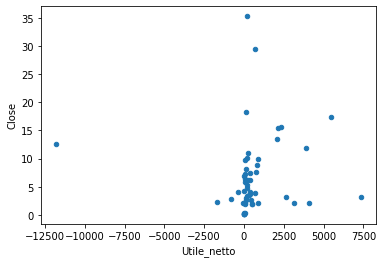

In [492]:
data.plot.scatter("Utile_netto", "Close")

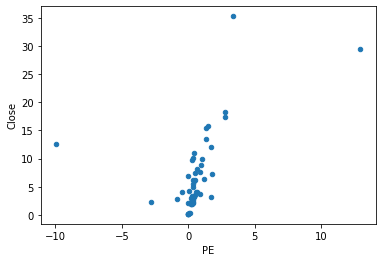

In [493]:
data.plot.scatter("PE", "Close")

**Correlazione non evidente con il primo grafico, mentre nel secondo potrebbe**

# Predizione Valore degli Indici di Borsa

## Predizione tramite modello a singolo record a valenza annuale

In [494]:
data.shape

(54, 9)

### Lista delle variabili

- Name: nome azienda
- Data: data di riferimento per tutte le variabili
- **Close: valore di chiusira del titolo**
  - vogliamo stimare il valore di questa variabile in funzione delle altre
- Volume: numero di transazioni della giornata di rilevamento dati perciò non ha senso tenerne conto
- Totale_ricavi: ricavi dell'anno precedente
- Costo_venduto: costi relativi a comprare la manodopera e il materiale
- Spese_generali_amministrative: tutte quelle spese che servono alla gestione di un'attività commerciale
- Spese_gestione_operativa: somma delle spese generali amministrative con le spese per ricerca e sviluppo
- Spese_interessi: interessi pagati durante l'anno sul debito che la società dichiara nello stato patrimoniale
- Utile_ante_imposte: indicatore economico determinato come differenza tra i ricavi e i costi aziendali, con l'eccezione delle imposte sul reddito
- Utile_netto: è il guadagno totale (o il profitto) di una società, calcolato prendendo i ricavi e sottraendo i costi di esercizio, come gli ammortamenti, gli interessi, le tasse e altre spese.
- PE: corrisponde all'utile netto di esercizio diviso per ogni azione in circolazione della società

# Regressione Lineare Multivariata

- Nella regressione multivariata una variabile dipendente è stimata su $n$ variabili indipendenti
- Il modello è rappresentabile come un iperpiano in $n+1$ dimensioni con $n+1$ parametri ($n$ coefficienti angolari più l'intercetta)
$$ h(\mathbf{x})=\theta_0+\sum_{i=1}^n\theta_i\cdot x_i=\mathbf{\theta}\cdot([1]\Vert\mathbf{x}) $$
- Un insieme di $m$ osservazioni su cui addestrare il modello può essere rappresentato da
  - una matrice $\mathbf{X}$ con $m\times n$ valori delle variabili indipendenti
  - un vettore $\mathbf{y}$ con i corrispondenti $m$ valori noti della variabile dipendente

## Dati per la Regressione

- Dobbiamo estrarre dai dati caricati la matrice X e il vettore y
- y è dato dalla colonna `Close` del frame
  - con `values` si estrae l'array dei valori contenuti in una serie o frame

In [495]:
y = data["Close"].values

- X è dato dall'intero frame ad esclusione della colonna `Close`
  - usiamo il metodo `drop` per ottenere una copia del frame senza la colonna

In [496]:
X = data.drop(columns=["Close"]).values

In [497]:
X.shape

(54, 8)

- Creiamo anche una matrice X1 dove a sinistra di X è aggiunta una colonna di 1, usando la funzione `hstack` ("horizontal stack") che concatena due matrici date

In [498]:
X1 = np.hstack([np.ones((X.shape[0], 1)), X])

## Discesa del Gradiente

- Implementiamo la discesa gradiente per trovare un modello ottimo al caso multivariato
- Creiamo una funzione `lr_gd_step` 
  - si ha un vettore `theta` di n+1 parametri
  - il calcolo avviene tra matrici (NB: `matrice.dot(vettore)` restituisce un vettore dei prodotti scalari di ciascuna riga della matrice col vettore)

In [499]:
def lr_gd_step(X1, y, theta, step_size):
    # calcolo l'errore su ciascun dato d'esempio
    error = X1.dot(theta) - y
    # calcolo il gradiente dell'errore, ovvero
    # la derivata parziale di ciascun parametro
    grad = 2 / X1.shape[0] * (X1.T.dot(error))
    # calcolo il nuovo valore di tutti i parametri
    new_theta = theta - step_size * grad
    return new_theta

- Utilizziamo la funzione in un ciclo per eseguire la discesa gradiente
  - partiamo da valori nulli e salviamo i parametri intermedi in una lista

In [500]:
theta = np.zeros(X1.shape[1])
theta_vals = [theta]
for iteration in range(50):
    theta = lr_gd_step(X1, y, theta, 0.000000001)
    theta_vals.append(theta)
theta_vals = np.array(theta_vals)

- **per la predizione generale imposteremo il passo a 0.000000001 range(50)**
- **per la predizione delle non banche imposteremo il passo a 0.000000002 range(100)**

- Abbiamo così ottenuto un vettore `theta` dei parametri del modello trovati con la discesa

In [501]:
theta

array([ 4.25994867e-07,  1.99154862e-04,  0.00000000e+00,  3.06919410e-05,
        1.33282899e-04,  2.42654110e-04, -3.75551779e-05, -1.54636905e-06,
        1.12318281e-06])

### Errore del Modello

- Calcoliamo il MSE compiuto dal modello sui dati
$$ E = \mathrm{media}\left(\left(h(\mathbf{x})-y\right)^2\right) = \mathrm{media}\left(\left(\mathbf{\theta}\cdot([1]\Vert\mathbf{x})-y\right)^2\right) $$

In [502]:
np.mean(np.square(X1.dot(theta) - y))

67.1856118649577

- Dalla progressione dei valori dei parametri, calcoliamo quella del MSE e visualizziamola in un grafico

In [503]:
mse_vals = np.mean(np.square(X1.dot(theta_vals.T) - y[:, None]), axis=0)

Text(0, 0.5, 'MSE')

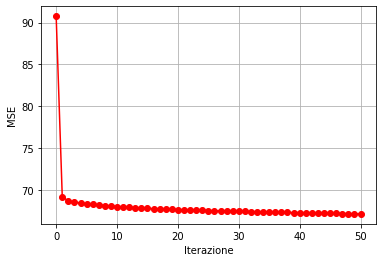

In [504]:
plt.plot(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("MSE")

#### Inferenza
- Sia dato un vettore di valori delle variabili indipendenti, ad esempio la prima riga di X

In [505]:
sample = X[0]

- Per calcolare il valore previsto di y, applichiamo la formula del modello lineare multivariato

In [506]:
theta[0] + theta[1:].dot(sample)

1.3372938017023144

- Per confronto, il valore reale è

In [507]:
y[0]

2.356

## scikit-learn

- Invece di implementare manualmente l'addestramento e l'uso di modelli, vediamo come usare una libreria apposita...
- _scikit-learn_ offre diversi algoritmi e funzioni di supporto per l'addestramento di modelli predittivi, inclusa la regressione lineare
  - tutti i tipi di modelli offrono un'interfaccia comune per l'addestramento e la predizione (_inferenza_)
  - i dati in ingresso sono rappresentati come array NumPy o serie/frame pandas

### Regressione Lineare

In [508]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression(normalize=True)

- Usiamo quindi `fit` per addestrare il modello, data la matrice delle variabili indipendenti e il vettore di quella dipendente, salvati in precedenza nelle variabili X  y

In [509]:
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

## Inferenza

- Una volta che il modello è addestrato, possiamo ottenere predizioni col metodo `predict`
  - va data in input una matrice o DataFrame $m\times n$ di osservazioni delle variabili indipendenti
  - è restituito un vettore di $m$ valori della variabile dipendente previsti dal modello
- Ad esempio, passiamo gli stessi dati usati per l'addestramento per vedere le predizioni del modello

In [510]:
y_pred = lrm.predict(X)

- Con tali predizioni possiamo calcolare l'errore compiuto dal modello

- MSE

In [511]:
np.mean(np.square(y_pred - y))

18.019295890731723

- Errore Relativo

In [512]:
np.mean(np.abs((y_pred - y) / y_pred))

0.6433629423110703

- R-squared 

In [513]:
lrm.score(X, y)

0.6142376074044367

- Possiamo ottenere dall'attributo `coef_` i coefficienti angolari usati dal modello
- Creando una serie possiamo associare ad ogni coefficiente angolare il nome della variabile corrispondente, per capire quali fenomeni influiscano positivamente e negativamente

In [514]:
pd.Series(lrm.coef_, index=data.columns[1:])

Totale_ricavi                    4.032212e-05
Costo_venduto                   -3.055334e-13
Spese_generali_amministrative   -1.409060e-04
Spese_gestione_operativa        -4.316822e-04
Spese_interessi                  2.700674e-03
Utile_ante_imposte               2.603154e-03
Utile_netto                     -3.748752e-03
PE                               2.546186e+00
dtype: float64

### Valutazione modello

In [515]:
data_train = data.iloc[:36]
data_val = data.iloc[36:]

- **per la predizione generale imposteremo il numero di righe a 200**
- **per la predizione delle non banche imposteremo il numero di righe a 174**
- **per la predizione delle banche imposteremo il numero di righe a 36**


- ho provato a normalizzarlo ma non varia i risultati

In [516]:
lrm = LinearRegression(normalize = True)
lrm.fit(data_train.drop(columns=["Close"]), data_train["Close"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [517]:
y_preds_train = lrm.predict(data_train.drop(columns=["Close"]))
np.mean(np.square(y_preds_train - data_train["Close"]))

22.825159044481094

In [518]:
y_preds_val = lrm.predict(data_val.drop(columns=["Close"]))
np.mean(np.square(y_preds_val - data_val["Close"]))

52.208353280590266

- possiamo notare come l'MSE del training set sia tre volte inferiore rispetto al validation set, ciò significa che il modello è troppo legato hai dati
- possibile causa è la maggior presenza di **banche** nel training set dovuto all'ordinamento

In [519]:
np.mean(np.abs((data_val["Close"] - y_preds_val) / data_val["Close"]))

4.824436986035583

In [520]:
np.mean(np.abs((data_train["Close"] - y_preds_train) / data_train["Close"]))

1.9624429908732313

# Predizione con Regressione non lineare

## Divisione tra Training e Validation Set
- Abbiamo visto che per verificare se un modello generalizza correttamente i dati su cui è addestrato, è importante validarlo su dati diversi
- Il metodo hold-out prevede di dividere i dati a disposizione in un training set su cui addestrare il modello e un validation set su cui verificare l'accuratezza
- A supporto del metodo hold-out, scikit-learn fornisce una funzione train_test_split per suddividere casualmente un set di dati in due insiemi "train" e "test" disgiunti
  - il set di dati può essere qualsiasi struttura dati sequenziale, di solito array NumPy o serie o DataFrame pandas
  - con l'opzione test_size=X si indica la proporzione (se X decimale tra 0 e 1) o il numero di elementi (se X intero) da inserire nel test piuttosto che nel train (default 0.25, ovvero 25\%)
  - con l'opzione random_state si indica un seed per la riproducibilità
- Ad esempio, dividiamo il DataFrame data in due parti train_data e val_data, contenenti rispettivamente 2/3 e 1/3 dei dati

- Eseguiamo la divisione casuale tra training e validation set 
  - la variabile dipendente y è Close, la quotazione
  - le variabili indipendenti X sono tutte le altre

In [521]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    data.drop("Close", axis=1),    # X = tutto tranne Close
    data["Close"],                 # y = Close
    test_size=1/3, random_state=42   # parametri divisione
)

## Misurare l'Errore del Modello
### Errore quadratico medio
- Per misurare l'errore che un modello $h(\mathbf{x})$ compie su un set di dati esistono diverse metriche
- L'_errore quadratico medio_ è utilizzato come criterio per individuare il modello migliore
$$ \mathrm{MSE} = \frac{1}{m}\sum_{i=1}^n\left(h(\mathbf{x}_i)-y_i\right)^2 $$
- Per calcolarlo possiamo usare la funzione `mean_squared_error` fornita da scikit-learn nel modulo `metrics`, che definisce diverse misure d'errore dei modelli

In [522]:
from sklearn.metrics import mean_squared_error

### Errore Relativo
- Altre misure sono utilizzate per ottenere una stima più facilmente interpretabile dell'errore
- L'_errore relativo_ misura intuitivamente di quanto il modello si sbaglia in percentuale rispetto al valore reale
$$ \mathrm{errore} = \frac{1}{m}\sum_{i=1}^m\left\vert\frac{h(\mathbf{x}_i)-y_i}{y_i}\right\vert $$
- Ad esempio, se il valore reale da predire è 2 GW, ad una stima di 2,2 GW corrisponde un errore relativo del 10\%
- Per questa metrica definiamo una funzione per il calcolo compatibile con quella usata sopra per il MSE

In [523]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

### Coefficente di Determinazione $R^2$
- Il _coefficiente di determinazione_ $R^2$ è una misura che esprime intuitivamente quanto il modello catturi la variabilità presente nei dati ($\bar{y}$ = media di $Y$)
$$ R^2 = \frac{\sum_{i=1}^m{\left(y_i-\hat{y}_i\right)^2}}{\sum_{i=1}^m{\left(y_i-\bar{y}\right)^2}} $$
- Il suo valore dovrebbe esssere compreso tra 0 e 1:
  - 1 indica che il modello descrive perfettamente i dati
  - 0 indica che non c'è alcuna relazione tra il modello ed i dati
- Questa metrica si può calcolare con la funzione `r2_score` del modulo `metrics` 
- In alternativa, essendo la metrica di default per i modelli di regressione, si può calcolare col metodo `score` del modello stesso passando le osservazioni delle variabili indipendenti e dipendente

- Per comodità, creiamo una funzione che calcoli e stampi tutte e tre le metriche su dati e modello forniti
  - format introduce valori in una stringa in corrispondenza dei segnaposto {...}
  - {:.5} indica di stampare un numero con 5 cifre decimali, con % lo si stampa in forma percentuale

In [524]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

### Predizione con Regressione Lineare semplice

- Addestriamo e valutiamo dapprima un modello lineare semplice
- Rispetto al caso precedente, il training ed il validation set saranno divisi casualmente

In [525]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [526]:
print_eval(X_val, y_val, model)

   Mean squared error: 13.222
       Relative error: 48.81293%
R-squared coefficient: 0.24252


- Osservando i coefficienti del modello etichettati con i nomi delle colonne, possiamo dedurre il peso che ciascuna variabile ha nella predizione
- Tuttavia, tali pesi dipendono molto dalla scala delle variabili

In [527]:
pd.Series(model.coef_, index=X_train.columns)

Totale_ricavi                    1.267318e-04
Costo_venduto                   -4.025925e-14
Spese_generali_amministrative   -2.855763e-03
Spese_gestione_operativa        -2.971499e-04
Spese_interessi                  2.520040e-03
Utile_ante_imposte               1.691613e-03
Utile_netto                     -2.980417e-03
PE                               2.529011e+00
dtype: float64

## Standardizzazione dei Dati

- Data una variabile $X$ con media $\mu$ e deviazione standard $\sigma$, la sua versione "standard" è calcolata come
$$ Z = \frac{X-\mu}{\sigma} $$
- $Z$ mantiene la distribuzione dei dati di $X$, ma con media 0 e deviazione standard 1
- In presenza di più variabili con scale diverse, applicare la standardizzazione a ciascuna di esse è utile per uniformarne i valori
- Questo può migliorare l'accuratezza dei modelli di regressione

- La standardizzazione si esegue col filtro `StandardScaler`
- Eseguendo `fit_transform` (o `fit`) il filtro memorizza medie e deviazioni standard dei dati passati

In [528]:
from sklearn.preprocessing import StandardScaler

- Per applicare la standardizzazione alle variabili basta aggiungere il filtro alla pipeline

## Pipeline

- scikit-learn permette di comporre uno o più filtri con un modello creando una **_pipeline_**
- Una volta costruita, la pipeline offre la **stessa API del modello** di predizione incapsulato, ma **applica automaticamente i filtri** ai dati prima di passarli al modello
  - chiamando `fit`, i filtri sono "tarati" e applicati (`fit_transform`) sui dati di addestramento
  - chiamando `predict` (o `score`), i filtri (già tarati) sono nuovamente applicati ai nuovi dati (`transform`)
  - al costruttore va passata la lista ordinata dei componenti, ciascuno rappresentato da una tupla con nome e componente

In [529]:
from sklearn.pipeline import Pipeline

- Applichiamo la standardizzazione ai dati del modello

In [530]:
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [531]:
print_eval(X_val, y_val, model)

   Mean squared error: 13.222
       Relative error: 48.81293%
R-squared coefficient: 0.24252


- In questo modo anche i coefficienti sono normalizzati, permettendone un confronto alla pari

In [532]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

Totale_ricavi                    1.887294e+00
Costo_venduto                    2.664535e-14
Spese_generali_amministrative   -2.028710e+00
Spese_gestione_operativa        -1.750003e+00
Spese_interessi                  5.629969e+00
Utile_ante_imposte               4.148976e+00
Utile_netto                     -7.426842e+00
PE                               7.315402e+00
dtype: float64

## Regressione Ridge

- La **_regolarizzazione Ridge_** modifica la funzione d'errore su cui si basa l'addestramento, aggiungendo una penalità per valori estremi dei parametri del modello
- Nella regolarizzazione _L2_, la più comune, la penalità è proporzionale al quadrato della norma euclidea del vettore $\mathbf{\theta}$ dei parametri
  - in questo modo parametri molto alti in valore assoluto sono molto penalizzati
- La regressione _ridge_ consiste nella regressione lineare con applicata la regolarizzazione L2, utilizzando quindi la seguente funzione d'errore:
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_2^2 $$
- $\alpha$ è un parametro impostabile dall'utente che controlla il "peso" della regolarizzazione
  - tali parametri impostabili sono a volte detti _iperparametri_ per distinguerli dai parametri addestrabili del modello

- Per eseguire la regressione ridge usiamo un modello `Ridge`
- Alla creazione del modello è possibile specificare il peso della regolarizzazione con l'opzione `alpha`
- Per il resto l'API della classe `Ridge` è identica a quella di `LinearRegression`, possiamo quindi sostituirla nella pipeline

In [533]:
from sklearn.linear_model import Ridge

In [534]:
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=5))
])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=0.001))],
         verbose=False)

In [535]:
print_eval(X_val, y_val, model)

   Mean squared error: 10.361
       Relative error: 57.17109%
R-squared coefficient: 0.40643


- Il modello ha un comportamento regolare anche per casi estremi ed otteniamo un miglioramento

## Regressione Lasso

- La regolarizzazione L2 impedisce che i parametri del modello assumano valori troppo alti
- I valori dei parametri sono comunque tutti non nulli, tutte le variabili vengono coinvolte nella predizione
- Vorremmo addestrare un modello meno complesso, dove alcuni parametri hanno valori nulli, **ignorando completamente le variabili meno rilevanti**
  - ad es. variabili con valori dipendenti da altre (_multicollinearità_)
- Questo si può ottenere tramite la regolarizzazione L1, basata sulla norma 1, definita su un vettore $\mathbf{x}$ di $n$ elementi come
$$ \left\Vert\mathbf{x}\right\Vert_1 = \sum_{i=1}^n{\left\vert x_i\right\vert} = \left\vert x_1\right\vert+\ldots+\left\vert x_n\right\vert $$

- La regressione _lasso_ consiste nella regressione lineare con regolarizzazione L1, basata quindi sul minimizzare la funzione d'errore
$$ E = \frac{1}{2m}\left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_1 $$
- Come per la regressione ridge, il parametro $\alpha$ controlla il peso della regolarizzazione
- La regressione lasso si esegue usando un modello `Lasso`, su cui possiamo impostare come in `Ridge` il parametro `alpha`

In [536]:
from sklearn.linear_model import Lasso

In [537]:
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Lasso(alpha=0.1))
])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 Lasso(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

- Vediamo i coefficienti del modello risultante

In [538]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

Totale_ricavi                    2.226480
Costo_venduto                    0.000000
Spese_generali_amministrative   -1.664100
Spese_gestione_operativa        -0.559246
Spese_interessi                  3.893572
Utile_ante_imposte              -0.000000
Utile_netto                     -3.662499
PE                               7.163093
dtype: float64

In [539]:
print_eval(X_val, y_val, model)

   Mean squared error: 11.691
       Relative error: 49.92542%
R-squared coefficient: 0.33021


**La regressione Lasso ha azzerato 3 valori e migliorato il modello**

## Elastic Net

- La regressione _elastic net_ combina insieme le regolarizzazioni L2 e L1 usate in ridge e lasso
- Si applica in scikit-learn tramite la classe `ElasticNet`, per cui l'errore è calcolato come:
$$ E = \underbrace{\frac{1}{2m} ||X\theta - y||_2 ^ 2}_{\text{errore sui dati}} + \underbrace{\alpha \rho ||\theta||_1}_{\text{L1}} + \underbrace{\frac{\alpha(1-\rho)}{2} ||\theta||_2 ^ 2}_{\text{L2}} $$
- I parametri impostabili sono
  - `alpha` ($\alpha$) che determina il peso generale della regolarizzazione
  - `l1_ratio` ($\rho$, compreso tra 0 e 1) che determina il peso di L1 relativo al totale (con $\rho=1$ si ha la regressione lasso, con $\rho=0$ la ridge)

In [540]:
from sklearn.linear_model import ElasticNet

In [541]:
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 10.232
       Relative error: 79.79328%
R-squared coefficient: 0.41381


# Regressione Polinomiale Multivariata

- Aumentando il grado massimo, le variabili generate **aumentano rapidamente**

In [542]:
from sklearn.preprocessing import PolynomialFeatures

In [543]:
poly = PolynomialFeatures(degree=12, include_bias=False)
poly.fit_transform(X_train).shape

(36, 125969)

- All'aumentare delle variabili, aumenta il tempo necessario per l'addestramento del modello
- Proviamo ad esempio ad addestrare un modello polinomiale di grado 2
- Usiamo il comando "magico" `%time` per riportare in output il tempo di esecuzione

In [544]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.5, l1_ratio=0.2))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Wall time: 2.97 ms
   Mean squared error: 9.0646
       Relative error: 47.86109%
R-squared coefficient: 0.48069


- ci mette pochissiomo con grado 2

In [545]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=10, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.5, l1_ratio=0.2))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3197202898652449, tolerance: 0.21651429836246172
  positive)


Wall time: 1.09 s
   Mean squared error: 544.77
       Relative error: 46.00502%
R-squared coefficient: -30.21


- oltre a metterci di più aumentano anche gli errori in maniera esponenziale
- con le **banche** R-coefficient è estremamente errato

## Regressione con Funzioni Kernel

- Nella regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente
- Le _funzioni kernel_ permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte
- Questo permette di ottenere modelli non lineari senza l'aggiunta di variabili
- Esistono diverse funzioni kernel utilizzabili con diversi parametri impostabili
- Ad esempio, il kernel polinomiale è definito dalla formula
$$ K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $$
  - $d$ e $c$ sono parametri del kernel, in particolare $d$ è il grado del polinomio

- La classe `KernelRidge` implementa la regressione ridge con l'applicazione di una funzione kernel
- Col parametro `kernel` si indica il tipo di kernel con una stringa, ad es. `"poly"` per un kernel polinomiale
- Ulteriori parametri riguardano il kernel, per quello polinomiale sono `degree` ($d$) e `coef0` ($c$)

In [546]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=0.1, kernel="poly", degree=10))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Wall time: 2.99 ms
   Mean squared error: 3.7816e+04
       Relative error: 81.25800%
R-squared coefficient: -2165.5


- Abbiamo ottenuto valori molto errati, ma in tempi molto più brevi rispetto alla regressione polinomiale

- Possiamo testare anche funzioni kernel diverse, ad esempio RBF (_radial basis function_)
  - RBF ha valori tanto più elevati quanto più i valori X sono vicini a 0 (ovvero la media, usando dati standardizzati)
- La funzione RBF ha la forma di una gaussiana, di cui si può impostare l'ampiezza col parametro `gamma`

In [547]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="rbf", gamma=0.001))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Wall time: 1.96 ms
   Mean squared error: 18.167
       Relative error: 70.77065%
R-squared coefficient: -0.040797


- in questo caso peggiora

## k-Fold Cross Validation

- Il metodo _k-fold_ è un'alternativa al metodo hold-out per valutare l'accuratezza di un modello
  - i dati sono divisi causalmente in k gruppi (_fold_)
  - ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi
  - i risultati dei singoli test sono aggregati
- Per iniziare, definiamo gli oggetti `X` e `y` con i valori di variabili indipendenti e dipendente dell'intero dataset, invece di usare le partizioni create con `train_test_split`

In [548]:
X = data.drop(["Close"], axis=1)
y = data["Close"]

- La classe `KFold` definisce oggetti che generano un dato numero di fold su un insieme di dati
- Creiamo ad esempio un oggetto che genera 5 fold con dati mescolati casualmente

In [549]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

- La funzione `cross_val_score` esegue una validazione di un modello sui diversi fold generati da un set di dati
- Alla funzione vanno passati
  - la definizione di un modello, che viene addestrato una volta per ciascun fold
  - i dati, divisi come per `fit` in valori delle variabili indipendenti (X) e di quella dipendente (y)
  - l'oggetto che genera i fold dai dati
- Utilizziamo ad esempio un modello polinomiale di grado 10 senza regolarizzazione

In [550]:
from sklearn.model_selection import cross_val_score
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

In [551]:
scores = cross_val_score(model, X, y, cv=kf)

- La funzione restituisce il risultato di `score`, ovvero il coefficiente R², calcolato su ciascun fold

In [552]:
scores

array([-3.00312780e+03, -1.92585854e+08, -2.43168129e+03, -1.50996797e+05,
       -1.74051561e+01])

- Calcoliamo media e deviazione standard di tali punteggi

In [553]:
scores.mean(), scores.std()

(-38548460.68530385, 77018718.54260015)

- **I punteggi sono fuori scala**
- Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello
- Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

- Riproviamo ad esempio la cross-validation con modello polinomiale come sopra, ma con regolarizzazione L2

In [554]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
scores = cross_val_score(model, X, y, cv=kf)
scores

array([ -0.46539156, -77.28588913, -13.32392068,   0.62326757,
         0.22123098])

In [555]:
scores.mean(), scores.std()

(-18.046140565650997, 30.076481074980073)

- I valori di R² individuati hanno una variabilità più bassa rispetto a quelli sopra nonostante siano comunque fuori scala
- per le **banche** disastro

## Grid Search

- Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri
  - grado della regressione polinomiale, peso della regolarizzazione, ...
- L'accuratezza del modello può dipendere fortemente da questi valori
- Scelto un generico modello da utilizzare (es. regressione polinomiale o kernel ridge), vorremmo **individuare i valori degli iperparametri che ne massimizzino l'accuratezza**
- scikit-learn fornisce un supporto per eseguire automaticamente la cross validation un modello con diversi valori degli iperparametri tramite la _grid search_

- Consideriamo ad esempio un modello _elastic net_ di cui fissiamo arbitrariamente il parametro `l1_ratio`

In [556]:
model = ElasticNet(l1_ratio=0.2)

- Vorremmo trovare il migliore valore possibile del parametro `alpha` tra un insieme di valori possibili, ovvero:

In [557]:
candidate_alphas = [0.01, 0.1, 0.5, 1, 2, 5, 10]

- Creiamo ora la _griglia_ dei parametri, ovvero un dizionario in cui associamo ai nomi dei parametri variabili i valori che possono assumere
- In questo caso abbiamo un unico parametro variabile, `alpha`

In [558]:
grid = {"alpha": candidate_alphas}

- Definiamo ora un modello `GridSearchCV` indicando
  - il modello "base" con i parametri fissati a priori
  - la griglia dei parametri variabili

In [559]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, param_grid=grid)

- Come per i modelli base, usiamo il metodo `fit` per eseguire l'addestramento, passando la matrice X e il vettore y
- Per ogni valore possibile di `alpha`, scikit-learn esegue la cross-validation per calcolare il punteggio R² medio del modello con quel valore di `alpha`
  - di default si esegue cross-validation con 3 fold

In [560]:
gs.fit(X_train, y_train)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356.6836430156827, tolerance: 0.19105116156576893
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.61444846688413, tolerance: 0.11592445622037811
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.4655

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.2, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

- In seguito ai test, il modello viene (di default) riaddestrato su tutti i dati, usando gli iperparametri che han dato il miglior punteggio medio
- Possiamo quindi utilizzarlo come un modello ordinario

In [561]:
print_eval(X_val, y_val, gs)

   Mean squared error: 13.076
       Relative error: 48.86697%
R-squared coefficient: 0.25085


- Dall'attributo `best_params_` possiamo vedere quali sono i valori selezionati degli iperparametri per tale modello

In [562]:
gs.best_params_

{'alpha': 1}

- L'attributo `cv_results_` fornisce risultati dettagliati su tutti gli iperparametri testati
- Incapsuliamo tali risultati in un DataFrame per visualizzarli meglio ed ordinarli per punteggio decrescente

In [563]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
3       0.001983      0.000017         0.001342    4.620714e-04           1   
4       0.004007      0.000835         0.000981    2.391671e-05           2   
2       0.002673      0.000450         0.000984    2.056858e-05         0.5   
5       0.002659      0.000470         0.000997    5.150430e-07           5   
6       0.002658      0.000469         0.000999    8.158535e-04          10   
1       0.002330      0.000485         0.001003    2.685360e-05         0.1   
0       0.003668      0.000477         0.001318    4.542319e-04        0.01   

            params  split0_test_score  split1_test_score  split2_test_score  \
3     {'alpha': 1}          -3.899948           0.548136           0.226266   
4     {'alpha': 2}          -3.903377           0.531510           0.201005   
2   {'alpha': 0.5}          -4.073604          -0.069608           0.240690   
5     {'alpha': 5}          -5.018717           0.156517           0.145689   
6    {'alpha': 10}          -7.275607          -0.076151           0.091209   
1   {'alpha': 0.1}          -4.342846          -3.175998           0.253235   
0  {'alpha': 0.01}          -4.423611          -5.238585           0.256190   

   mean_test_score  std_test_score  rank_test_score  
3        -1.041849        2.025248                1  
4        -1.056954        2.017243                2  
2        -1.300841        1.964728                3  
5        -1.572170        2.437081                4  
6        -2.420183        3.433983                5  
1        -2.421870        1.950645                6  
0        -3.135335        2.421140                7

- Cosa succede con due iperparametri variabili?
- Oltre a 3 valori possibili per `alpha`, impostiamo 3 valori possibili anche per `l1_ratio`

In [564]:
model = ElasticNet()
grid = {
    "alpha":    [0.1, 0.5, 1, 2, 5, 10],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
gs = GridSearchCV(model, param_grid=grid)
gs.fit(X_train, y_train)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357.08899731351016, tolerance: 0.19105116156576893
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.92773086256764, tolerance: 0.11592445622037811
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.387

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.74193303941519, tolerance: 0.11592445622037811
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.067816803126135, tolerance: 0.12543314344188677
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.14634190786506, tolerance: 0.19105116156576893
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5, 10],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [565]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
18       0.000000      0.000000         0.000000    0.000000e+00           2   
19       0.007498      0.006398         0.000328    4.635029e-04           2   
17       0.000000      0.000000         0.005203    7.358390e-03           2   
10       0.001994      0.000001         0.000997    9.199649e-07           1   
16       0.000000      0.000000         0.000000    0.000000e+00           2   
11       0.002004      0.000012         0.000996    1.106929e-06           1   
15       0.000000      0.000000         0.005207    7.364010e-03           2   
12       0.001889      0.000947         0.000332    4.700217e-04           1   
13       0.000000      0.000000         0.000000    0.000000e+00           1   
5        0.002320      0.000448         0.001008    1.866107e-05         0.5   
6        0.002328      0.000475         0.000995    8.099216e-06         0.5   
24       0.002316      0.000470         0.001013    1.538041e-05           5   
7        0.002664      0.000455         0.001012    2.094920e-05         0.5   
14       0.005221      0.007383         0.000000    0.000000e+00           1   
23       0.002323      0.000455         0.000998    3.371748e-07           5   
22       0.002340      0.000473         0.000993    8.904507e-06           5   
21       0.002326      0.000467         0.000992    6.633009e-06           5   
20       0.001992      0.000007         0.001017    6.613937e-06           5   
8        0.002643      0.000461         0.001006    1.068430e-05         0.5   
9        0.001995      0.000020         0.000998    2.973602e-07         0.5   
0        0.002814      0.000255         0.000995    2.697398e-06         0.1   
25       0.002315      0.000473         0.001008    9.114813e-06          10   
26       0.002323      0.000474         0.001004    2.922181e-06          10   
1        0.002961      0.000022         0.001030    1.209659e-05         0.1   
27       0.002298      0.000461         0.001000    2.617277e-05          10   
2        0.002659      0.000451         0.000997    3.417204e-05         0.1   
28       0.002003      0.000023         0.001003    5.611707e-06          10   
3        0.002673      0.000449         0.000989    2.983632e-05         0.1   
4        0.002650      0.000473         0.000667    4.719468e-04         0.1   
29       0.001998      0.000822         0.000659    4.663469e-04          10   

   param_l1_ratio                           params  split0_test_score  \
18            0.7    {'alpha': 2, 'l1_ratio': 0.7}          -3.750089   
19            0.9    {'alpha': 2, 'l1_ratio': 0.9}          -3.706913   
17            0.5    {'alpha': 2, 'l1_ratio': 0.5}          -3.806110   
10            0.1    {'alpha': 1, 'l1_ratio': 0.1}          -3.901775   
16            0.3    {'alpha': 2, 'l1_ratio': 0.3}          -3.869787   
11            0.3    {'alpha': 1, 'l1_ratio': 0.3}          -3.899565   
15            0.1    {'alpha': 2, 'l1_ratio': 0.1}          -3.937699   
12            0.5    {'alpha': 1, 'l1_ratio': 0.5}          -3.903727   
13            0.7    {'alpha': 1, 'l1_ratio': 0.7}          -3.915604   
5             0.1  {'alpha': 0.5, 'l1_ratio': 0.1}          -4.065726   
6             0.3  {'alpha': 0.5, 'l1_ratio': 0.3}          -4.082175   
24            0.9    {'alpha': 5, 'l1_ratio': 0.9}          -4.389694   
7             0.5  {'alpha': 0.5, 'l1_ratio': 0.5}          -4.101531   
14            0.9    {'alpha': 1, 'l1_ratio': 0.9}          -3.936835   
23            0.7    {'alpha': 5, 'l1_ratio': 0.7}          -4.622429   
22            0.5    {'alpha': 5, 'l1_ratio': 0.5}          -4.806479   
21            0.3    {'alpha': 5, 'l1_ratio': 0.3}          -4.954843   
20            0.1    {'alpha': 5, 'l1_ratio': 0.1}          -5.077000   
8             0.7  {'alpha': 0.5, 'l1_ratio': 0.7}          -4.124071   
9             0.9  {'alpha': 0.5, 'l1_ratio': 0.9}          -4.

- scikit-learn ha generato e testato **tutte le combinazioni possibili** dei valori degli iperparametri, in tutto $6\times 5=30$ configurazioni

In [566]:
print_eval(X_val, y_val, gs)

   Mean squared error: 13.07
       Relative error: 49.12611%
R-squared coefficient: 0.25123


- possiamo osservare dalla grid search che il modello predilige la regressione ridge per le **generiche**

- Possiamo usare `GridSearchCV` anche con una pipeline, testando diversi valori anche per i parametri dei filtri
- Consideriamo ad esempio un modello polinomiale di grado variabile con regolarizzazione L2

In [567]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])

- Per riferirsi ai parametri dei singoli componenti usiamo la notazione `nomeComponente__parametro`

In [568]:
grid = {
    "poly__degree": [2, 3, 4],      # <- grado polinomio
    "regr__alpha":  [0.1, 1, 5, 10, 50] # <- regolarizzazione
}
gs = GridSearchCV(model, param_grid=grid)

In [569]:
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4        0.002317      0.000477         0.001340    4.819916e-04   
9        0.003657      0.000470         0.001995    1.123916e-07   
3        0.002325      0.000472         0.000989    1.264743e-05   
14       0.005652      0.000470         0.004321    4.702468e-04   
8        0.003657      0.000471         0.002327    4.704151e-04   
2        0.002668      0.000458         0.001322    4.756991e-04   
11       0.006981      0.001410         0.004654    9.407739e-04   
13       0.005319      0.000470         0.003989    1.946680e-07   
7        0.004654      0.001695         0.002659    9.403806e-04   
1        0.002985      0.000009         0.000995    1.821195e-05   
0        0.003000      0.000814         0.001668    4.740016e-04   
12       0.005651      0.000470         0.003990    2.973602e-07   
6        0.007646      0.004630         0.002993    8.146855e-04   
10       0.007314      0.001244         0.005651    1.243624e-03   
5        0.003980      0.000013         0.001995    1.123916e-07   

   param_poly__degree param_regr__alpha  \
4                   2                50   
9                   3                50   
3                   2                10   
14                  4                50   
8                   3                10   
2                   2                 5   
11                  4                 1   
13                  4                10   
7                   3                 5   
1                   2                 1   
0                   2               0.1   
12                  4                 5   
6                   3                 1   
10                  4               0.1   
5                   3               0.1   

                                     params  split0_test_score  \
4    {'poly__degree': 2, 'regr__alpha': 50}          -0.873753   
9    {'poly__degree': 3, 'regr__alpha': 50}          -2.228936   
3    {'poly__degree': 2, 'regr__alpha': 10}          -7.974683   
14   {'poly__degree': 4, 'regr__alpha': 50}          -9.307233   
8    {'poly__degree': 3, 'regr__alpha': 10}         -36.801124   
2     {'poly__degree': 2, 'regr__alpha': 5}         -37.369604   
11    {'poly__degree': 4, 'regr__alpha': 1}         -84.335674   
13   {'poly__degree': 4, 'regr__alpha': 10}        -153.227842   
7     {'poly__degree': 3, 'regr__alpha': 5}        -163.326476   
1     {'poly__degree': 2, 'regr__alpha': 1}        -196.399497   
0   {'poly__degree': 2, 'regr__alpha': 0.1}        -203.340711   
12    {'poly__degree': 4, 'regr__alpha': 5}        -281.574403   
6     {'poly__degree': 3, 'regr__alpha': 1}       -3060.893531   
10  {'poly__degree': 4, 'regr__alpha': 0.1}       -6121.366065   
5   {'poly__degree': 3, 'regr__alpha': 0.1}      -28058.463730   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
4            0.380981           0.028852        -0.154640        0.528420   
9            0.419772           0.006653        -0.600837        1.163528   
3            0.650873           0.082123        -2.413896        3.938920   
14           0.463613          -0.015698        -2.953106        4.497305   
8            0.602892           0.045048       -12.051061       17.502419   
2           -0.007131           0.107724       -12.423004       17.639973   
11         -14.774824           0.231765       -32.959578       36.841343   
13           0.537620           0.017863       -50.890786       72.363537   
7           -0.389892           0.076531       -54.546612       76.919215   
1           -7.673868           0.204407       -67.956319       90.879973   
0          -36.611842           0.448721       -79.834611       88.632909   
12          -0.702978           0.055478       -94.073968      132.583191   
6          -12.261936           0.220800     -1024.311555     1440.089942   
10         -72.495194           0.569438     -2064.430607     2868.841647   
5          -60

In [570]:
print_eval(X_val, y_val, gs)

   Mean squared error: 10.544
       Relative error: 42.23830%
R-squared coefficient: 0.39596


## Grid Search su Kernel Ridge

- Creo una funzione grid_test che, preso in input un modello e una griglia di parametri esegue una grid search con X_train, y_train come dati di addestramento con modello e parametri forniti
- stamperà il dizionario con gli iperparametri selezionati del modello migliore
- stamperà le misure di accuratezza sui dati X_val, y_val

In [571]:
def grid_test(X_train, y_train, X_val, y_val, model, grid):
    gs = GridSearchCV(model, param_grid=grid)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print_eval(X_val, y_val, gs)

**Modello Elastic Net Normalizzato**

In [572]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  ElasticNet())
])
grid = {
    "poly__degree":   [2, 3],
    "regr__alpha":    [0.1, 1, 5, 10],
    "regr__l1_ratio": [0.1, 0.25, 0.5, 0.75]
}
grid_test(X_train, y_train, X_val, y_val, model, grid)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.62642763794793, tolerance: 0.19105116156576893
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.5333827294796, tolerance: 0.11592445622037811
  positive)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.260518

{'poly__degree': 2, 'regr__alpha': 1, 'regr__l1_ratio': 0.5}
   Mean squared error: 11.833
       Relative error: 46.48075%
R-squared coefficient: 0.32208


**Modello Kernel Ridge Normalizzato**

In [573]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2, 11),
    "regr__alpha":  [0.01, 0.1, 1, 10]
}
grid_test(X_train, y_train, X_val, y_val, model, grid)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'regr__alpha': 10, 'regr__degree': 2}
   Mean squared error: 9.2242
       Relative error: 48.28172%
R-squared coefficient: 0.47154


- se fornisco 'regr__alpha': 20, seleziona quello ma restituisce risultati più scarsi

#### Grid Search Lasso Normalizzato

In [574]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  Lasso())
])
grid = {
    "regr__alpha":  [0.01, 0.1, 0.2, 0.6, 1, 2, 5, 10]
}
grid_test(X_train, y_train, X_val, y_val, model, grid)

{'regr__alpha': 10}
   Mean squared error: 21.043
       Relative error: 56.33287%
R-squared coefficient: -0.20555


C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\enric\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43544313298787074, tolerance: 0.19105116156576893
  positive)


# Abbiamo potuto notare che tutti i modelli sopra analizzati sono fallimentali con alcune eccezioni di miglioramento.

- il modello con l'MSE migliore è quello della Regressione lineare con tutti i dati (119.25) ed a seguire con (127.69) la Grid Search (Polinomiale, Ridge, standardizzata, con iperparametri (grado 2, alpha 10))


- riguardo l'Errore Relativo, il migliore è quello della Regressione Lasso (alpha 0.1) con tutti i dati (73.35%) ed a seguire con (73.68%) la Regressione Ridge con (alpha 5)


- il Coefficente di Determinazione R-squared migliore è quello della Regressione Lineare semplice (0.36), a seguire nella Regressione Polinomiale Ridge Standardizzato {'poly__degree': 2, 'regr__alpha': 50}	 mi viene (0.32).

# Ora proviamo un approccio diverso tenendo conto dello storico. Innanzitutto considereremo i dati con abbinato anche l'anno antecedente.

- Creiamo un altro DataFrame con l'aggiunta delle variabili: 
    - PE_anno_antecedente
    - Close_anno_antecedente
    - Percentuale_anno_antecedente

In [575]:
data_2 = data.copy()

In [576]:
data_2["PE_anno_antecedente"] = data_2["PE"].shift(1)

In [577]:
data_2["Close_anno_antecedente"] = data_2["Close"].shift(1)

In [578]:
data_2["Percentuale_anno_antecedente"] = 100*(data_2["Close"] - data_2["Close"].shift(1)) / data_2["Close"].shift(1)

In [579]:
data_2.head(60)

Close  Totale_ricavi  Costo_venduto  \
Name Date                                                  
BAMI 2017-02-01   2.356000         3174.0            0.0   
     2018-02-01   3.107000         2866.0            0.0   
     2019-02-01   2.132000         2622.0            0.0   
BDB  2017-02-01   2.170000          462.6            0.0   
     2018-02-01   2.130000          460.0            0.0   
     2019-02-01   1.925000          419.0            0.0   
BMED 2017-02-01   6.165000         3637.0            0.0   
     2018-02-01   7.420000         3383.0            0.0   
     2019-02-01   6.130000         2092.0            0.0   
BPE  2017-02-01   4.310000         2158.0            0.0   
     2018-02-01   4.868000         2092.0            0.0   
     2019-02-01   3.715000         2271.5            0.0   
BPSO 2017-02-01   3.002000          933.0            0.0   
     2018-02-01   3.330000         1001.5            0.0   
     2019-02-01   2.574000          932.6            0.0   
BSRP 2017-02-01   6.310000          381.5            0.0   
     2018-02-01   6.840000          374.8            0.0   
     2019-02-01   7.280000          352.0            0.0   
CASS 2017-02-01   5.920000         4805.0            0.0   
     2018-02-01   9.790000         5059.0            0.0   
     2019-02-01   8.190000         5740.0            0.0   
FBK  2017-02-01   5.400000          648.7            0.0   
     2018-02-01  10.120000          666.0            0.0   
     2019-02-01  10.925000          720.2            0.0   
G    2017-02-01  13.520000        80259.0            0.0   
     2018-02-01  15.440000        82183.0            0.0   
     2019-02-01  15.695000        67925.0            0.0   
IF   2017-02-01  29.500000          360.0            0.0   
     2018-02-01  35.259998          593.5            0.0   
     2019-02-01  18.350000          467.8            0.0   
IKG  2017-02-01   0.200700            0.1            0.0   
     2018-02-01   0.310000           44.9            0.0   
     2019-02-01   0.341000           33.2            0.0   
ISP  2017-02-01   2.200000        27785.0            0.0   
     2018-02-01   3.096000        26263.0            0.0   
     2019-02-01   2.169000        29087.0            0.0   
MB   2017-02-01   7.565000         2377.0            0.0   
     2018-02-01   9.854000         2278.0            0.0   
     2019-02-01   8.822000         2260.0            0.0   
PRO  2017-02-01   0.200800           54.1            0.0   
     2018-02-01   0.222000           63.7            0.0   
     2019-02-01   0.171200           57.5            0.0   
UBI  2017-02-01   2.811690         3222.0            0.0   
     2018-02-01   3.969000         3843.0            0.0   
     2019-02-01   2.621000         4186.0            0.0   
UCG  2017-02-01  12.647700        18821.0            0.0   
     2018-02-01  17.445999        19671.0            0.0   
     2019-02-01  11.966000        20674.0            0.0   
UNI  2017-02-01   3.586000        16549.0            0.0   
     2018-02-01   4.112000        13093.0            0.0   
     2019-02-01   4.007000        13848.0            0.0   
US   2017-02-01   2.000000        13811.0            0.0   
     2018-02-01   1.978500        12890.0            0.0   
     2019-02-01   2.196000        13268.0            0.0   

                 Spese_generali_amministrative  Spese_gestione_operativa  \
Name Date                                                                  
BAMI 2017-02-01                          259.0                    2624.0   
     2018-02-01                         1283.0                    -425.0   
     2019-02-01                         1246.0                    2631.0   
BDB  2017-02-01                           77.7                     352.5   
     2018-02-01                           71.7                     319.7   
     2019-02-01                          128.7                     312.0   
BMED 2017-02-01                          294.4      

In [580]:
len(data_2.index)

54

- Elimino le righe errate

In [581]:
for i in range(0, len(data.index)):
    if (i % 3 == 2):
        data_2.drop(data_2.index[(len(data.index)-1) -i], inplace=True)

In [582]:
len(data_2.index)

36

In [583]:
data_2.head(60)

Close  Totale_ricavi  Costo_venduto  \
Name Date                                                  
BAMI 2018-02-01   3.107000         2866.0            0.0   
     2019-02-01   2.132000         2622.0            0.0   
BDB  2018-02-01   2.130000          460.0            0.0   
     2019-02-01   1.925000          419.0            0.0   
BMED 2018-02-01   7.420000         3383.0            0.0   
     2019-02-01   6.130000         2092.0            0.0   
BPE  2018-02-01   4.868000         2092.0            0.0   
     2019-02-01   3.715000         2271.5            0.0   
BPSO 2018-02-01   3.330000         1001.5            0.0   
     2019-02-01   2.574000          932.6            0.0   
BSRP 2018-02-01   6.840000          374.8            0.0   
     2019-02-01   7.280000          352.0            0.0   
CASS 2018-02-01   9.790000         5059.0            0.0   
     2019-02-01   8.190000         5740.0            0.0   
FBK  2018-02-01  10.120000          666.0            0.0   
     2019-02-01  10.925000          720.2            0.0   
G    2018-02-01  15.440000        82183.0            0.0   
     2019-02-01  15.695000        67925.0            0.0   
IF   2018-02-01  35.259998          593.5            0.0   
     2019-02-01  18.350000          467.8            0.0   
IKG  2018-02-01   0.310000           44.9            0.0   
     2019-02-01   0.341000           33.2            0.0   
ISP  2018-02-01   3.096000        26263.0            0.0   
     2019-02-01   2.169000        29087.0            0.0   
MB   2018-02-01   9.854000         2278.0            0.0   
     2019-02-01   8.822000         2260.0            0.0   
PRO  2018-02-01   0.222000           63.7            0.0   
     2019-02-01   0.171200           57.5            0.0   
UBI  2018-02-01   3.969000         3843.0            0.0   
     2019-02-01   2.621000         4186.0            0.0   
UCG  2018-02-01  17.445999        19671.0            0.0   
     2019-02-01  11.966000        20674.0            0.0   
UNI  2018-02-01   4.112000        13093.0            0.0   
     2019-02-01   4.007000        13848.0            0.0   
US   2018-02-01   1.978500        12890.0            0.0   
     2019-02-01   2.196000        13268.0            0.0   

                 Spese_generali_amministrative  Spese_gestione_operativa  \
Name Date                                                                  
BAMI 2018-02-01                         1283.0                    -425.0   
     2019-02-01                         1246.0                    2631.0   
BDB  2018-02-01                           71.7                     319.7   
     2019-02-01                          128.7                     312.0   
BMED 2018-02-01                          288.0                    2988.0   
     2019-02-01                          294.0                    1681.0   
BPE  2018-02-01                          295.0                    1519.0   
     2019-02-01                          316.0                    1625.0   
BPSO 2018-02-01                          160.5                     560.0   
     2019-02-01                          159.8                     557.0   
BSRP 2018-02-01                          102.7                     273.3   
     2019-02-01                          108.6                     295.0   
CASS 2018-02-01                          154.2                     154.2   
     2019-02-01                          219.5                     219.5   
FBK  2018-02-01                           77.4                     347.0   
     2019-02-01                           82.0                     354.4   
G    2018-02-01                         2575.0                       0.0   
     2019-02-01                         2438.0                       0.0   
IF   2018-02-01                           98.2                     281.7   
     2019-02-01                          101.4                     294.7   
IKG  2018-02-01                            3.0                      

### Divisione tra Training e Validation Set

In [584]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(
    data_2.drop("Close", axis=1),    # X = tutto tranne Close
    data_2["Close"],                 # y = Close
    test_size=1/3, random_state=42   # parametri divisione
)

### K-Fold Cross Validation
- Valuteremo R² su ogni modello

In [585]:
X_2 = data_2.drop(["Close"], axis=1)
y_2 = data_2["Close"]
kf = KFold(5, shuffle=True, random_state=42)

### Predizione 2 con Regressione Lineare Semplice Standardizzata

In [586]:
model_2 = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
model_2.fit(X_train_2, y_train_2)
print_eval(X_val_2, y_val_2, model_2)

   Mean squared error: 38.356
       Relative error: 84.54479%
R-squared coefficient: -0.0022817


- Osservando i coefficienti del modello etichettati con i nomi delle colonne, possiamo dedurre il peso che ciascuna variabile ha nella predizione
- Con le **banche** R-squared si azzera

In [587]:
pd.Series(model_2.named_steps["linreg"].coef_, X_train_2.columns)

Totale_ricavi                    1.536979e-01
Costo_venduto                    2.220446e-15
Spese_generali_amministrative   -6.852323e-01
Spese_gestione_operativa        -1.418403e+00
Spese_interessi                  1.334997e-01
Utile_ante_imposte               2.676844e+00
Utile_netto                     -1.253621e+00
PE                               8.004389e-01
PE_anno_antecedente              3.556589e+00
Close_anno_antecedente           3.229598e+00
Percentuale_anno_antecedente     1.490454e+00
dtype: float64

- Possiamo notare che tiene conto delle variabili aggiunte ma ciò non migliora la predizione

##### K-Fold Cross Validation

In [588]:
scores = cross_val_score(model_2, X_2, y_2, cv=kf)
scores

array([-0.16835296,  0.90353149, -0.57117004, -0.7328236 ,  0.66293217])

In [589]:
scores.mean(), scores.std()

(0.0188234118511341, 0.6550854879402869)

- risultati stabili
- per **banche** valori inaccettabili e instabili

### Predizione 2 con Regressione Lineare Ridge Standardizzata, Grid Search

In [595]:
model_2 = Pipeline([
    ("scale", StandardScaler()),
    ("linreg",  Ridge())
])
grid_2 = {
    "linreg__alpha":    range(30, 50),
}
grid_test(X_train_2, y_train_2, X_val_2, y_val_2, model_2, grid_2)

{'linreg__alpha': 30}
   Mean squared error: 33.506
       Relative error: 105.36991%
R-squared coefficient: 0.12446


C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


##### K-Fold Cross Validation

In [596]:
scores = cross_val_score(model_2, X_2, y_2, cv=kf)
scores

array([-0.21624448,  0.90350396,  0.0932547 ,  0.7650654 ,  0.68942642])

In [597]:
scores.mean(), scores.std()

(0.4470012013719706, 0.43205578407920453)

- stabile con **tutte le società**
- valori buoni e stabili per le società **non banche**
- per le **banche** instabile ed inaccettabile

### Predizione 2 con Regressione Lineare Lasso Standardizzata, Grid Search

In [599]:
model_2 = Pipeline([
    ("scale", StandardScaler()),
    ("linreg",  Lasso())
])
grid_2 = {
    "linreg__alpha":    [0.1, 0.5, 1, 1.5]
}
grid_test(X_train_2, y_train_2, X_val_2, y_val_2, model_2, grid_2)

{'linreg__alpha': 0.1}
   Mean squared error: 33.993
       Relative error: 221.35213%
R-squared coefficient: 0.11173


C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


##### K-Fold Cross Validation

In [600]:
scores = cross_val_score(model_2, X_2, y_2, cv=kf)
scores

array([-0.09846799,  0.75391848, -0.07423593,  0.56668291,  0.62924034])

In [601]:
scores.mean(), scores.std()

(0.3554275613223356, 0.3657947930146224)

- Valori accettabili per **tutte le società**
- Valori stabili per le **non banche**
- Valori inaccettabili per le **banche**

### Predizione 2 con Regressione Lineare Elastic Net Standardizzata, Grid Search

In [602]:
model_2 = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  ElasticNet())
])
grid_2 = {
    "regr__alpha":    [0.01, 0.1, 0.5, 1, 1.5, 5],
    "regr__l1_ratio": [0.1, 0.25, 0.5, 0.80, 0.90, 0.95]
}
grid_test(X_train_2, y_train_2, X_val_2, y_val_2, model_2, grid_2)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'regr__alpha': 0.5, 'regr__l1_ratio': 0.1}
   Mean squared error: 30.532
       Relative error: 147.34864%
R-squared coefficient: 0.20216


##### K-Fold Cross Validation

In [603]:
scores = cross_val_score(model_2, X_2, y_2, cv=kf)
scores

array([ 0.16448539,  0.68555096,  0.72201702, -0.84808899,  0.54846464])

In [604]:
scores.mean(), scores.std()

(0.25448580405170923, 0.5855932756119021)

- Valori poco stabili per **tutte le società**
- Valori bassi ma abbastanza stabili per **non banche**
- Valori disastrosi per le **banche**

### Predizione 2 con Regressione Polinomiale Kernel Ridge Standardizzata, Grid Search

In [605]:
model_2 = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly"))
])
grid_2 = {
    "regr__degree": range(1, 10),
    "regr__alpha":  [0.01, 0.1, 1, 5, 20, 30]
}
grid_test(X_train_2, y_train_2, X_val_2, y_val_2, model_2, grid_2)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'regr__alpha': 0.1, 'regr__degree': 3}
   Mean squared error: 59.841
       Relative error: 140.25000%
R-squared coefficient: -0.5637


- Predilige la Regressione di grado 1 per le società **generiche**
- per le **banche** grado 3 ma valori errati

##### K-Fold Cross Validation

In [606]:
scores = cross_val_score(model_2, X_2, y_2, cv=kf)
scores

array([ -0.51762235,   0.89806207,   0.40916221, -34.0216895 ,
         0.84814517])

In [607]:
scores.mean(), scores.std()

(-6.476788480422968, 13.781818630345947)

- molto instabile per **tutte le società**
- valori buoni per **non banche**
- valori fuori scala per **banche**

### Predizione 2 con Regressione Kernel Radial Basis Function Standardizzata, Grid Search

- Possiamo testare anche funzioni kernel diverse, ad esempio RBF (radial basis function)
- RBF ha valori tanto più elevati quanto più i valori X sono vicini a 0 (ovvero la media, usando dati standardizzati)
- La funzione RBF ha la forma di una gaussiana, di cui si può impostare l'ampiezza col parametro gamma

In [608]:
model_2 = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="rbf"))
])
grid_2 = {
    "regr__alpha":  [0.01, 0.1, 1, 5, 20, 30],
    "regr__gamma":  [0.001, 0.01, 0.1, 1]
}
grid_test(X_train_2, y_train_2, X_val_2, y_val_2, model_2, grid_2)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'regr__alpha': 0.01, 'regr__gamma': 0.001}
   Mean squared error: 32.159
       Relative error: 1643.30972%
R-squared coefficient: 0.15966


- Otteniamo un buon coefficente R² ed anche l' MSE cala notevolmente ma abbiamo un'esplosione dell'errore relativo.

##### K-Fold Cross Validation

In [609]:
scores = cross_val_score(model_2, X_2, y_2, cv=kf)
scores

array([-0.72006899,  0.57806701, -0.10816792,  0.21675399, -0.47375851])

In [610]:
scores.mean(), scores.std()

(-0.10143488362941562, 0.4656920365569174)

- Valori molto instabili per società **generiche**
- Valori instabili e scarsi **non banche**
- Valori inaccettabili per **banche**

# Avendo abbinato anche l'anno precedente abbiamo riscontrato un miglioramento generale di tutti i metodi.

- il modello con l'MSE migliore è quello Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.01, 'regr__degree': 2} con (2.99) a seguire quello della Regressione Kernel Radial Basis Function Standardizzato {'regr__alpha': 0.01, 'regr__gamma': 0.01} con (8.73).

- riguardo l'Errore Relativo, il migliore è quello della Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.01, 'regr__degree': 2} con (31.52%) a seguire quello della Regressione Lineare Ridge Standardizzata {'linreg__alpha': 30} con (46.52%).

- il Coefficente di Determinazione R-squared migliore è quello Regressione Lineare Lasso Standardizzato {'linreg__alpha': 0.5} con (0.93) di media k-fold, a seguire quello della Regressione Lineare Semplice Standardizzato con (0.926) a pari con  Regressione Lineare Ridge Standardizzato {'linreg__alpha': 30} che ha (0.929).

# Approfondiamo il concetto di storico abbinando ai dati le variabili degli ultimi due anni.

- Creiamo un altro DataFrame con l'aggiunta delle variabili: 
    - PE_secondo_anno_antecedente
    - Close_secondo_anno_antecedente
    - Percentuale_secondo_anno_antecedente

In [611]:
data_3 = data.copy()

In [612]:
data_3["PE_anno_antecedente"] = data_3["PE"].shift(1)
data_3["PE_secondo_anno_antecedente"] = data_3["PE"].shift(2)

In [613]:
data_3["Close_anno_antecedente"] = data_3["Close"].shift(1)
data_3["Close_secondo_anno_antecedente"] = data_3["Close"].shift(2)

In [614]:
data_3["Percentuale_anno_antecedente"] = 100*(data_3["Close"] - data_3["Close"].shift(1)) / data_3["Close"].shift(1)
data_3["Percentuale_secondo_anno_antecedente"] = 100*(data_3["Close"].shift(1) - data_3["Close"].shift(2)) / data_3["Close"].shift(2)

In [615]:
data_3.head(7)

Close  Totale_ricavi  Costo_venduto  \
Name Date                                              
BAMI 2017-02-01  2.356         3174.0            0.0   
     2018-02-01  3.107         2866.0            0.0   
     2019-02-01  2.132         2622.0            0.0   
BDB  2017-02-01  2.170          462.6            0.0   
     2018-02-01  2.130          460.0            0.0   
     2019-02-01  1.925          419.0            0.0   
BMED 2017-02-01  6.165         3637.0            0.0   

                 Spese_generali_amministrative  Spese_gestione_operativa  \
Name Date                                                                  
BAMI 2017-02-01                          259.0                    2624.0   
     2018-02-01                         1283.0                    -425.0   
     2019-02-01                         1246.0                    2631.0   
BDB  2017-02-01                           77.7                     352.5   
     2018-02-01                           71.7                     319.7   
     2019-02-01                          128.7                     312.0   
BMED 2017-02-01                          294.4                    3205.0   

                 Spese_interessi  Utile_ante_imposte  Utile_netto    PE  \
Name Date                                                                 
BAMI 2017-02-01           1066.0             -2296.0      -1681.0 -2.77   
     2018-02-01            923.0              1698.0       2616.0  1.73   
     2019-02-01            569.0              -272.0        -59.0 -0.04   
BDB  2017-02-01             72.8                27.5         25.5  0.19   
     2018-02-01             52.5                64.6         43.7  0.33   
     2019-02-01             51.9                43.3         35.2  0.27   
BMED 2017-02-01            128.4               449.0        393.5  0.53   

                 PE_anno_antecedente  PE_secondo_anno_antecedente  \
Name Date                                                           
BAMI 2017-02-01                  NaN                          NaN   
     2018-02-01                -2.77                          NaN   
     2019-02-01                 1.73                        -2.77   
BDB  2017-02-01                -0.04                         1.73   
     2018-02-01                 0.19                        -0.04   
     2019-02-01                 0.33                         0.19   
BMED 2017-02-01                 0.27                         0.33   

                 Close_anno_antecedente  Close_secondo_anno_antecedente  \
Name Date                                                                 
BAMI 2017-02-01                     NaN                             NaN   
     2018-02-01                   2.356                             NaN   
     2019-02-01                   3.107                           2.356   
BDB  2017-02-01                   2.132                           3.107   
     2018-02-01                   2.170                           2.132   
     2019-02-01                   2.130                           2.170   
BMED 2017-02-01                   1.925                           2.130   

                 Percentuale_anno_antecedente  \
Name Date                                       
BAMI 2017-02-01                           NaN   
     2018-02-01                     31.876061   
     2019-02-01                    -31.380753   
BDB  2017-02-01                      1.782364   
     2018-02-01                     -1.843318   
     2019-02-01                     -9.624413   
BMED 2017-02-01                    220.259740   

                 Percentuale_secondo_anno_antecedente  
Name Date                                              
BAMI 2017-02-01                                   NaN  
     2018-02-01                                   NaN  
     2019-02-01                             31.876061  
BDB  2017-02-01                            -31.380753  
     2018-02-01                              1.782364  
     2019-02-01    

In [616]:
len(data_3.index)

54

- Elimino le righe errate

In [617]:
for i in range(0, len(data.index)):
    if (i % 3 != 0):
        data_3.drop(data_3.index[(len(data.index)-1) -i], inplace=True)

In [618]:
len(data_3.index)

18

In [619]:
data_3.tail(4)

Close  Totale_ricavi  Costo_venduto  \
Name Date                                               
UBI  2019-02-01   2.621         4186.0            0.0   
UCG  2019-02-01  11.966        20674.0            0.0   
UNI  2019-02-01   4.007        13848.0            0.0   
US   2019-02-01   2.196        13268.0            0.0   

                 Spese_generali_amministrative  Spese_gestione_operativa  \
Name Date                                                                  
UBI  2019-02-01                          483.3                    3201.0   
UCG  2019-02-01                         1215.0                   11813.0   
UNI  2019-02-01                          596.7                       0.0   
US   2019-02-01                          530.8                       0.0   

                 Spese_interessi  Utile_ante_imposte  Utile_netto    PE  \
Name Date                                                                 
UBI  2019-02-01            346.8               390.7        425.6  0.34   
UCG  2019-02-01           4894.0              3593.0       3892.0  1.71   
UNI  2019-02-01            170.4              1185.0        401.4  0.56   
US   2019-02-01             96.0              1203.0        905.1  0.33   

                 PE_anno_antecedente  PE_secondo_anno_antecedente  \
Name Date                                                           
UBI  2019-02-01                 0.65                        -0.87   
UCG  2019-02-01                 2.79                        -9.93   
UNI  2019-02-01                -0.49                         0.47   
US   2019-02-01                 0.18                         0.18   

                 Close_anno_antecedente  Close_secondo_anno_antecedente  \
Name Date                                                                 
UBI  2019-02-01                3.969000                         2.81169   
UCG  2019-02-01               17.445999                        12.64770   
UNI  2019-02-01                4.112000                         3.58600   
US   2019-02-01                1.978500                         2.00000   

                 Percentuale_anno_antecedente  \
Name Date                                       
UBI  2019-02-01                    -33.963215   
UCG  2019-02-01                    -31.411208   
UNI  2019-02-01                     -2.553502   
US   2019-02-01                     10.993177   

                 Percentuale_secondo_anno_antecedente  
Name Date                                              
UBI  2019-02-01                             41.160654  
UCG  2019-02-01                             37.938115  
UNI  2019-02-01                             14.668154  
US   2019-02-01                             -1.075000

### Divisione tra Training e Validation Set

In [620]:
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(
    data_3.drop("Close", axis=1),    # X = tutto tranne Close
    data_3["Close"],                 # y = Close
    test_size=1/3, random_state=42   # parametri divisione
)

### K-Fold Cross Validation
- Valuteremo R² su ogni modello

In [621]:
X_3 = data_3.drop(["Close"], axis=1)
y_3 = data_3["Close"]
kf = KFold(5, shuffle=True, random_state=42)

### Predizione 3 con Regressione Lineare Semplice Standardizzata

In [622]:
model_3 = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
model_3.fit(X_train_3, y_train_3)
print_eval(X_val_3, y_val_3, model_3)

   Mean squared error: 28.655
       Relative error: 805.13052%
R-squared coefficient: -0.060694


- Osservando i coefficienti del modello etichettati con i nomi delle colonne, possiamo dedurre il peso che ciascuna variabile ha nella predizione

In [623]:
pd.Series(model_3.named_steps["linreg"].coef_, X_train_3.columns)

Totale_ricavi                          -2.961036e+00
Costo_venduto                           3.730349e-14
Spese_generali_amministrative           3.492952e+00
Spese_gestione_operativa               -8.220625e+00
Spese_interessi                        -1.151503e-01
Utile_ante_imposte                      4.990164e+00
Utile_netto                             2.299229e+00
PE                                     -4.404978e+00
PE_anno_antecedente                    -9.252141e-01
PE_secondo_anno_antecedente            -1.074058e+00
Close_anno_antecedente                  1.014589e+01
Close_secondo_anno_antecedente         -2.779504e-01
Percentuale_anno_antecedente           -7.860545e-01
Percentuale_secondo_anno_antecedente    7.810293e-01
dtype: float64

- Possiamo notare il peso che assumono le nuove variabili

##### K-Fold Cross Validation

In [624]:
scores = cross_val_score(model_3, X_3, y_3, cv=kf)
scores

array([-6.66249803e-01, -6.73082565e+01, -4.28887345e+04, -1.40337969e-01,
       -5.12026081e+00])

In [625]:
scores.mean(), scores.std()

(-8592.393917820355, 17148.18903864049)

- continua ad aumentare la media
- per **banche** disastroso, fuori scala

### Predizione 3 con Regressione Lineare Ridge Standardizzata, Grid Search

In [626]:
model_3 = Pipeline([
    ("scale", StandardScaler()),
    ("linreg",  Ridge())
])
grid_3 = {
    "linreg__alpha":    range(1, 70),
}
grid_test(X_train_3, y_train_3, X_val_3, y_val_3, model_3, grid_3)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'linreg__alpha': 6}
   Mean squared error: 11.307
       Relative error: 50.10900%
R-squared coefficient: 0.58146


##### K-Fold Cross Validation

In [627]:
scores = cross_val_score(model_3, X_3, y_3, cv=kf)
scores

array([0.76013468, 0.9655979 , 0.06589467, 0.31047005, 0.27659709])

In [628]:
scores.mean(), scores.std()

(0.4757388777550632, 0.3334025614860282)

- risultati buoni per **generiche**, non per l'errore relativo
- peggiorano per **non banche**
- valori scarsi e altalenanti **banche**

### Predizione 3 con Regressione Lineare Lasso Standardizzata, Grid Search

In [629]:
model_3 = Pipeline([
    ("scale", StandardScaler()),
    ("linreg",  Lasso())
])
grid_3 = {
    "linreg__alpha":    [0.1, 0.5, 1, 2, 2.5, 4]
}
grid_test(X_train_3, y_train_3, X_val_3, y_val_3, model_3, grid_3)

{'linreg__alpha': 1}
   Mean squared error: 9.9978
       Relative error: 51.95926%
R-squared coefficient: 0.62992


C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


##### K-Fold Cross Validation

In [630]:
scores = cross_val_score(model_3, X_3, y_3, cv=kf)
scores

array([0.57950896, 0.86894815, 0.72885018, 0.15136827, 0.68114133])

In [631]:
scores.mean(), scores.std()

(0.6019633789715172, 0.24379927576913277)

- valori ottimi per **generiche**
- valori abbastanza stabili per **non banche**
- valori quasi buoni e poco stabili per **banche**

### Predizione 3 con Regressione Lineare Elastic Net Standardizzata, Grid Search

In [632]:
model_3 = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  ElasticNet())
])
grid_3 = {
    "regr__alpha":    [0.1, 1, 1.5, 5],
    "regr__l1_ratio": [0.1, 0.5, 0.75, 0.85, 0.90]
}
grid_test(X_train_3, y_train_3, X_val_3, y_val_3, model_3, grid_3)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'regr__alpha': 1, 'regr__l1_ratio': 0.9}
   Mean squared error: 9.6497
       Relative error: 49.64452%
R-squared coefficient: 0.6428


##### K-Fold Cross Validation

In [633]:
scores = cross_val_score(model_3, X_3, y_3, cv=kf)
scores

array([ 0.57604662,  0.8173587 ,  0.91356503, -0.13435062,  0.45909553])

In [634]:
scores.mean(), scores.std()

(0.5263430502925387, 0.36827700610288894)

- valori discreti per le società **generiche**
- stabili ma non troppo buoni per **non banche**
- valori scarsi per **banche** ed inaffidabili

### Predizione 3 con Regressione Polinomiale Kernel Ridge Standardizzata, Grid Search

In [635]:
model_3 = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly"))
])
grid_3 = {
    "regr__degree": range(1, 10),
    "regr__alpha":  [0.01, 0.1, 1, 5, 8, 10, 12]
}
grid_test(X_train_3, y_train_3, X_val_3, y_val_3, model_3, grid_3)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'regr__alpha': 1, 'regr__degree': 1}
   Mean squared error: 15.682
       Relative error: 59.72327%
R-squared coefficient: 0.4195


- finalmente predilige il grado 2 per le **generiche**

##### K-Fold Cross Validation

In [636]:
scores = cross_val_score(model_3, X_3, y_3, cv=kf)
scores

array([ 0.1534297 ,  0.63112502,  0.36681432, -0.11061321, -0.05795655])

In [637]:
scores.mean(), scores.std()

(0.19655985582074065, 0.27525536025785585)

- valori ottimi per **generiche**
- valori buoni per **non banche**
- risultati inadeguati per le **banche** 

### Predizione 3 con Regressione Kernel Radial Basis Function Standardizzata, Grid Search

In [638]:
model_3 = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="rbf"))
])
grid_3 = {
    "regr__alpha":  [0.001, 0.01, 0.1, 1],
    "regr__gamma":  [0.001, 0.01, 0.1, 1]
}
grid_test(X_train_3, y_train_3, X_val_3, y_val_3, model_3, grid_3)

{'regr__alpha': 0.01, 'regr__gamma': 0.001}
   Mean squared error: 11.077
       Relative error: 48.73512%
R-squared coefficient: 0.58997


C:\Users\enric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


##### K-Fold Cross Validation

In [639]:
scores = cross_val_score(model_3, X_3, y_3, cv=kf)
scores

array([-1.05465796, -0.86152251, -0.94858381, -1.05497712,  0.2767085 ])

In [640]:
scores.mean(), scores.std()

(-0.7286065795251938, 0.5078468805776856)

- valori inaccettabili per **generiche**
- valori inaccettabili per **non banche**
- per **banche** risultati inadeguati

# Avendo abbinato fino a due anni antecedenti abbiamo riscontrato un miglioramento generale di quasi tutte le metodologie.

- il modello con l'MSE migliore è quello Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.1, 'regr__degree': 2} con (5.32) a seguire quello della Regressione Kernel Radial Basis Function Standardizzato {'regr__alpha': 0.001, 'regr__gamma': 0.001} con (6.42).


- riguardo l'Errore Relativo, il migliore è quello della Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.1, 'regr__degree': 2} con (21.28%) a seguire Regressione Kernel Radial Basis Function Standardizzato {'regr__alpha': 0.001, 'regr__gamma': 0.001} con (41.63%).


- il Coefficente di Determinazione R-squared migliore è quello Regressione Lineare Lasso Standardizzato {'linreg__alpha': 1} con (0.957) di media nel k-fold validation a seguire quello della Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.1, 'regr__degree': 2} con (0.952) nel k-fold.

### Il miglior metodo per società Generiche è:
   ### - la Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.1, 'regr__degree': 2} predizione 3

# Conclusioni sulle società non banche

- il modello con l'MSE migliore è quello Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.01, 'regr__degree': 2} con (0.68) predizione 2, a seguire quello della Regressione Kernel Radial Basis Function Standardizzato {'regr__alpha': 0.01, 'regr__gamma': 0.01} con (1.28) predizione 2.


- riguardo l'Errore Relativo, il migliore è quello della Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.01, 'regr__degree': 2} con (12.26%) predizione 2, a seguire quello della Regressione Lineare Elastic Net Standardizzato {'regr__alpha': 1, 'regr__l1_ratio': 0.9} con (35.35%) nella predizione 3.


- il Coefficente di Determinazione R-squared migliore è quello Regressione Lineare Ridge Standardizzato {'linreg__alpha': 30} con (0.944) nel k-fold validation nella predizione 2, a seguire quello della Regressione Lineare Lasso Standardizzato {'linreg__alpha': 0.5} con (0.943) nel k-fold validation nella predizione 2.

### Il miglior metodo è:
   ### - la Regressione Polinomiale Kernel Ridge Standardizzato {'regr__alpha': 0.01, 'regr__degree': 2} predizione 2
- Mean squared error: 0.68389
-     Relative error: 12.25905%
- R-squared coefficient: 0.99754

# Conclusioni sulle società banche

- il modello con l'MSE migliore è quello Regressione Polinomiale Multivariata Standardizzato {alpha=0.5, l1_ratio=0.2} con (9.06) nella predizione 1, a seguire quello della Regressione Kernel Ridge Standardizzato {'regr__alpha': 10, 'regr__degree': 2} con (9.22) nella predizione 1.


- riguardo l'Errore Relativo, il migliore è quello della Regressione Polinomiale Ridge Standardizzato {'poly__degree': 2, 'regr__alpha': 50} con (42.24%) nel caso senza gli anni precedenti, a seguire quello della Regressione Polinomiale Elastic Net Standardizzato {alpha=0.5, l1_ratio=0.2, degree=10} con (46.01%) nella predizione 1.


- il Coefficente di Determinazione R-squared migliore è quello Regressione Lineare Lasso Standardizzato {'linreg__alpha': 1} con (0.60) nel k-fold validation nella predizione 3, a seguire quello della Regressione Lineare Elastic Net Standardizzato {'regr__alpha': 1, 'regr__l1_ratio': 0.9} con (0.53 0.37) nel k-fold validation nella predizione 3.

### Il miglior metodo è:
   ### - la Regressione Lineare Lasso Standardizzato {'linreg__alpha': 1} predizione 3
   
- Mean squared error: 9.9978
- Relative error: 51.95926%
- R-squared coefficient: 0.62992